Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile

from matplotlib import pylab
from six.moves import range, xrange
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name)).split()
  f.close()
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5240, 3082, 12, 6, 195, 2, 3135, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'originated', 'anarchism', 'a', 'as', 'of', 'term', 'originated']


In [292]:
data_index = 280
batch_size = 4
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

print([reverse_dictionary[i] for i in data[data_index:data_index + batch_size + skip_window]])

b, l = generate_batch(batch_size=batch_size, num_skips=1, skip_window=skip_window)

print([reverse_dictionary[i] for i in b])
print([[reverse_dictionary[x] for x in i] for i in l])

['including', 'the', 'the', 'anarchy', 'organisation']
['the', 'the', 'anarchy', 'organisation']
[['including'], ['the'], ['the'], ['and']]


Train a skip-gram model.

In [156]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [149]:
embed.get_shape()
#embeddings.get_shape()
#train_dataset.get_shape()

TensorShape([Dimension(128), Dimension(128)])

In [31]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.770839
Nearest to this: pitman, playfulness, whites, curfew, heavily, manicheanism, romania, completion,
Nearest to about: yad, you, peers, homophobia, sahara, sitting, turing, mclaughlin,
Nearest to after: venerable, castille, robbie, mph, icebergs, sombre, deviant, classes,
Nearest to first: iana, corollary, proposals, decryption, maru, employees, hooper, pfeiffer,
Nearest to a: auvergne, onscreen, palaestina, refrigerants, fer, falun, hautes, designing,
Nearest to years: maoism, aberrations, schumacher, llama, higham, djvu, layoffs, transmutation,
Nearest to one: prokofiev, okinawa, metafont, maniac, matres, qualification, connick, jsf,
Nearest to if: unpaved, goal, twelfth, cu, andamans, sable, bitrate, berkman,
Nearest to of: unforeseen, incompressible, cassatt, biota, roleplay, harrisburg, registered, interpreted,
Nearest to in: alg, westcott, montreal, dives, heinlein, evaporated, incomplete, pflp,
Nearest to than: past, fuze, sue, domestic,

In [190]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [75]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

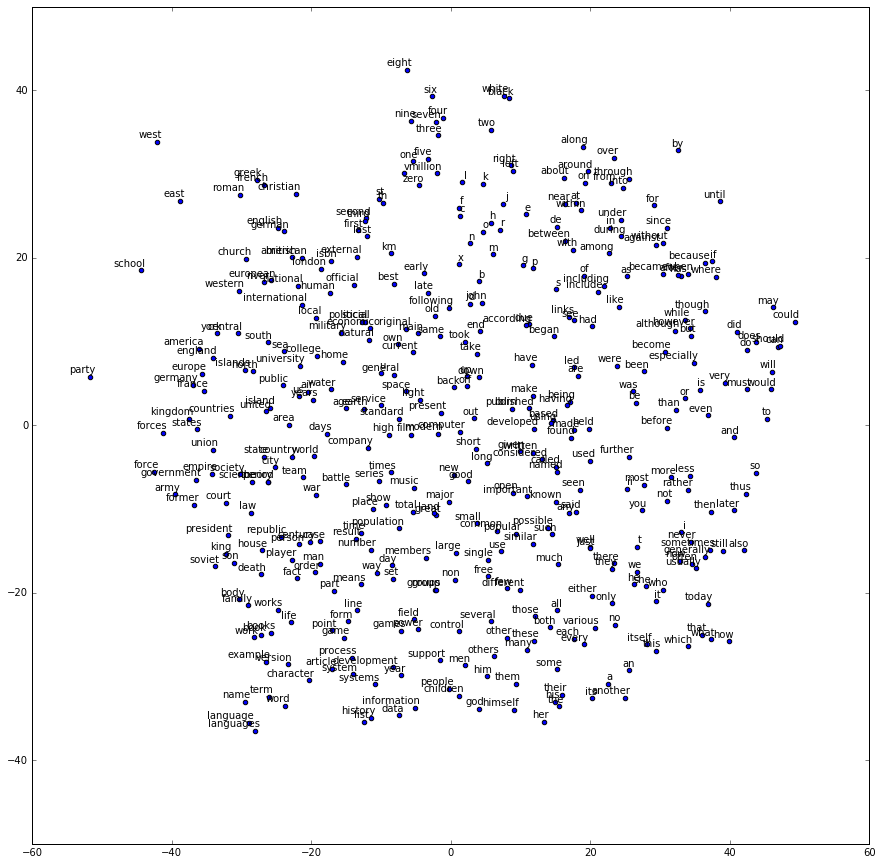

In [36]:
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [67]:
from itertools import groupby

data_index = 0
def cbow_generate_batch(batch_size, num_skips, skip_window):
    batch, labels = generate_batch(batch_size, num_skips, skip_window)
    
    new_batch = np.ndarray(shape=(batch_size // num_skips, num_skips), dtype=np.int32)
    new_labels = np.ndarray(shape=(batch_size // num_skips, 1), dtype=np.int32)
    
    groups = groupby(zip(batch, labels.flatten()), lambda x: x[0])
    groups = [[[g[0]], [t[1] for t in g[1]]] for g in groups]

    batch_pointer = 0
    group_pointer = 0
    while group_pointer < len(groups):
        current_group = groups[group_pointer]
        if len(current_group[1]) <= num_skips:
            new_batch[batch_pointer] = current_group[1]
            new_labels[batch_pointer] = current_group[0]
            group_pointer += 1
            batch_pointer += 1
        else:
            # handle groupby can create the 2nd element has length larger than num_skips
            new_batch[batch_pointer] = current_group[1][:num_skips]
            new_labels[batch_pointer] = current_group[0]
            batch_pointer += 1
            current_group[1] = current_group[1][num_skips:]

    return new_batch, new_labels


In [71]:
data_index = 280

source, target = cbow_generate_batch(6, 2, 1)

print([[reverse_dictionary[s[0]], reverse_dictionary[s[1]]] for s in source])
print([[reverse_dictionary[t[0]]] for t in target])

[['including', 'the'], ['anarchy', 'the'], ['the', 'organisation'], ['anarchy', 'and']]
[['the'], ['the'], ['anarchy'], ['organisation']]


In [69]:
data_index = 280
batch_size = 6
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

print([reverse_dictionary[i] for i in data[data_index:data_index + batch_size + skip_window]])

b, l = generate_batch(batch_size=batch_size, num_skips=1, skip_window=skip_window)

print([reverse_dictionary[i] for i in b])
print([[reverse_dictionary[x] for x in i] for i in l])

['including', 'the', 'the', 'anarchy', 'organisation', 'and', 'rothbard']
['the', 'the', 'anarchy', 'organisation', 'and', 'rothbard']
[['including'], ['anarchy'], ['organisation'], ['and'], ['organisation'], ['find']]


In [182]:
ss = tf.InteractiveSession()

embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embeddings.initializer.run()

embedded = tf.nn.embedding_lookup(embeddings, source)


print(tf.reduce_sum(embedded.eval(), 1).eval())

ss.close()

[[  1.09291077e-03  -1.18570900e+00   5.70280075e-01   1.59949780e+00
    8.68658066e-01   1.42631793e+00  -4.25270557e-01   1.30629182e+00
   -9.05044556e-01   7.28031874e-01   1.86787605e-01  -6.95449114e-01
    7.66567945e-01  -3.00110340e-01  -6.66592836e-01   5.91043472e-01
   -8.07185888e-01  -8.77796173e-01   1.29127431e+00   5.11617899e-01
    1.87616587e-01  -3.10459137e-01   1.00779772e+00   1.92783642e+00
   -4.11276102e-01  -8.86295080e-01  -6.85449839e-01   9.55438614e-01
    2.76214838e-01   5.67329884e-01  -1.13451862e+00   3.04038048e-01
   -1.68424487e+00   4.97176170e-01   2.01957703e-01   1.45686221e+00
   -4.09498215e-02  -1.54582381e+00  -6.27356768e-01   2.47197390e-01
    9.66793776e-01  -7.65132904e-03   1.05677128e+00   1.85532355e+00
   -1.43544912e-01  -1.07475138e+00  -1.15864849e+00   6.56690359e-01
    1.97092533e-01  -6.00893021e-01   3.94217968e-01  -3.14472198e-01
   -1.23041391e-01   8.07782650e-01   4.80265379e-01   2.16080189e-01
    1.01467729e+00  

In [72]:
data_index = 0
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size / num_skips, num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size / num_skips, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  if num_skips > 1:
    embed = tf.reduce_sum(embed, 1)
    
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [73]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = cbow_generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.524155
Nearest to a: cited, niles, autocrat, commence, divinity, atalanta, dietrich, urbino,
Nearest to called: aloysius, brownish, clampett, numerator, liar, vedic, breads, ode,
Nearest to who: ferrari, veitch, eec, lorna, rats, primal, minimax, analyzer,
Nearest to state: chimp, uwe, bernhard, paula, superstition, smiths, ilp, lately,
Nearest to history: expropriation, pollution, handguns, nuremberg, airbase, alphorn, roofed, prasad,
Nearest to he: decoy, kulaks, fils, toho, rudd, nagarjuna, balanced, ebbinghaus,
Nearest to of: hus, meyer, clowns, masterpiece, bordered, rhyming, mysia, greens,
Nearest to while: disprove, ncc, langle, adsorption, thessalian, coldest, toile, helices,
Nearest to years: anyone, conciliar, drastic, arica, ralston, mauritania, sikh, fortaleza,
Nearest to an: jacoby, superposition, simile, swaziland, reassessment, assad, audita, sommerfeld,
Nearest to as: anjiro, cinque, handicaps, miniatures, ub, hedgehog, outage, prof

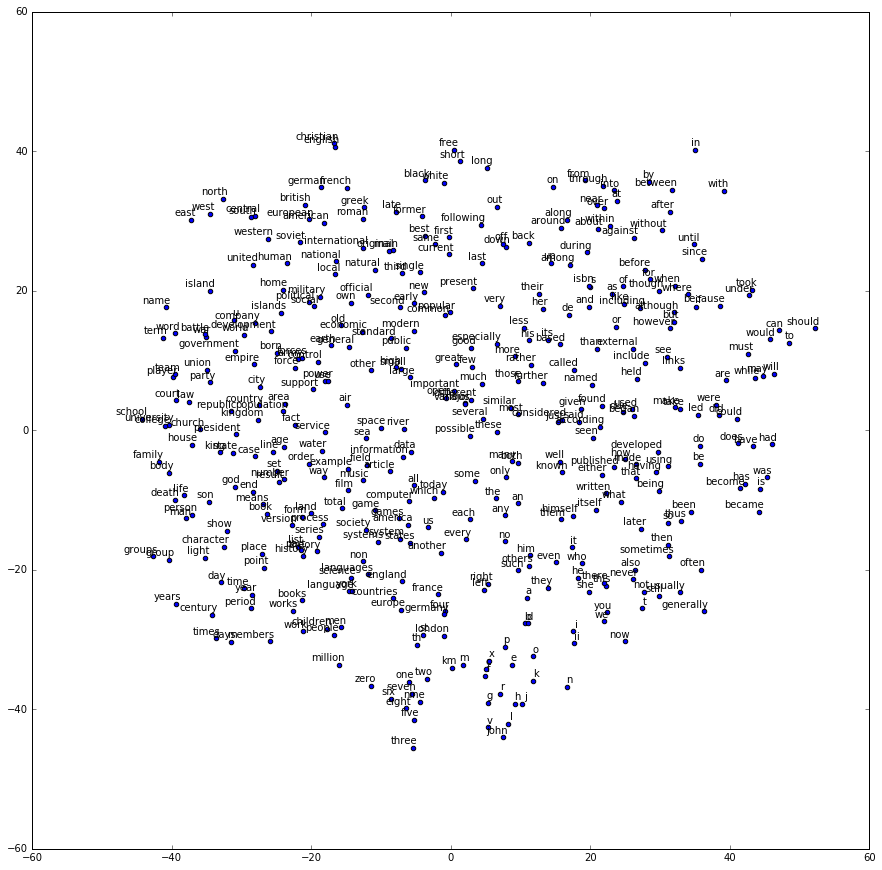

In [77]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)